# Sementic segmentation of flair1 data with a basic UNet

In [ ]:
!git clone https://github.com/BertilleT/LandCover_map_Transformers_SSL.git
!pip install rasterio

In [16]:
# import all the necessary modules
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
from utils import *
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from pathlib import Path
import random
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
dict_classes = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'swimming_pool',
14  : 'snow',
15  : 'clear cut',
16  : 'mixed',
17  : 'ligneous',
18  : 'greenhouse',
19  : 'other'}

colors = {
1   : '#db0e9a',
2   : '#938e7b',
3   : '#f80c00',
4   : '#a97101',
5   : '#1553ae',
6   : '#194a26',
7   : '#46e483',
8   : '#f3a60d',
9   : '#660082',
10  : '#55ff00',
11  : '#fff30d',
12  : '#e4df7c',
13  : '#3de6eb',
14  : '#ffffff',
15  : '#8ab3a0',
16  : '#6b714f',
17  : '#c5dc42',
18  : '#9999ff',
19  : '#000000'}

## Prepare the data
1) Download the data and split it into training, validation and test sets.
2) Analyse the balance of classes in the dataset.
3) Create a Dataloader
4) Load the data

In [3]:
class Flair1Dataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, seed = 42):
        super(Flair1Dataset, self).__init__()
        self.resize_transform = transforms.Resize((256, 256))
        self.resize_transform_l = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
        self.folder_path = folder_path
        self.img_files = sorted(list(get_data_paths(Path(self.folder_path), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.mask_files = sorted(list(get_data_paths(Path(self.folder_path), 'mask*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.total = len(self.img_files)
        self.n_classes = 13
        self.n_inputs = 3

    def __len__(self):
        return self.total

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        data = rasterio.open(img_path).read()
        data = data[0:3, :, :]
        label = rasterio.open(mask_path).read()
        label = label - 1
        # Convert data to PIL Image for resizing
        data = np.transpose(data, (1, 2, 0))
        data = transforms.ToPILImage()(data)
        data = self.resize_transform(data)
        # Convert back to tensor
        data = transforms.ToTensor()(data)

        # Convert label to PIL Image for resizing
        label = np.transpose(label, (1, 2, 0))
        label = transforms.ToPILImage()(label)
        label = self.resize_transform_l(label)
        #print values uniques in label
        # Convert back to tensor
        label = torch.from_numpy(np.array(label, dtype=np.uint8))
        label = label.long()

        #Turn data and label into float between 0 and 1
        # data = data / 255
        # label = label / 255
        return data, label

    def get_per_per_class(self):
        class_per = dict.fromkeys(range(1,20), 0)
        total_pixels = 0
        for i in range(len(self)):
            _, label = self[i]
            for j in range(1,20):
                class_per[j] += torch.sum(label == j).item()
            total_pixels += label.numel()
        for j in range(1,20):
            class_per[j] = class_per[j] / total_pixels
        return class_per


In [17]:
#folder_path = 'LandCover_map_Transformers_SSL/data/flair1_subset/'
train_path = '../data/flair1_subset/train_500'
val_path = '../data/flair1_subset/val_100'
test_path = '../data/flair1_subset/test_100'
batch_size = 2
use_gpu = True
max_epochs = 2

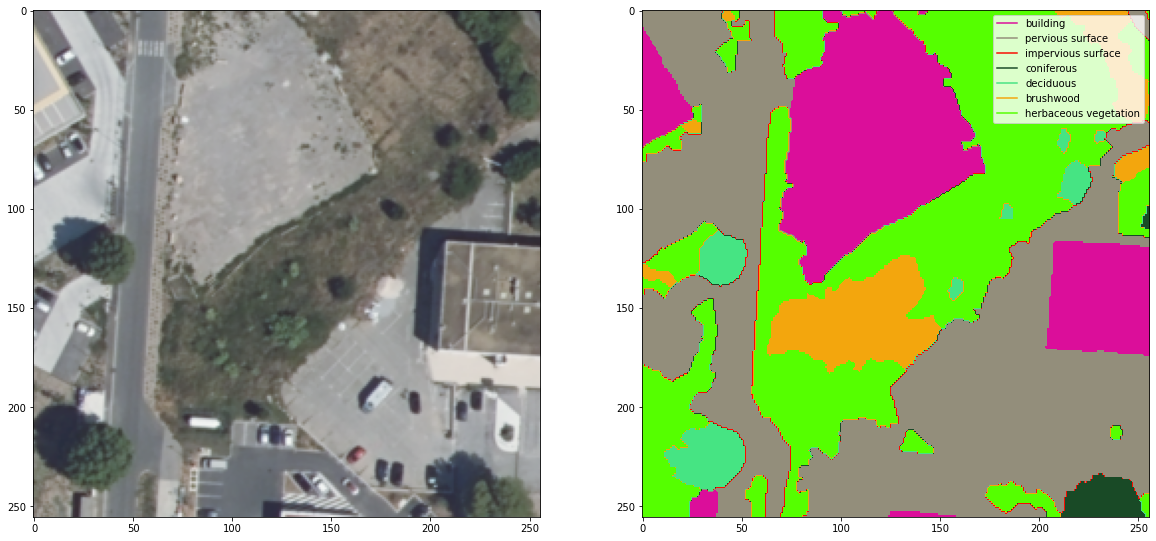

In [10]:
toy_ds = Flair1Dataset(train_path)
toy_dl = torch.utils.data.DataLoader(toy_ds, batch_size=batch_size, shuffle=True)
img, msk = next(iter(toy_dl))
plot_image_mask_2(img[0], msk[0], colors, dict_classes)

In [18]:
train_ds = Flair1Dataset(train_path)
val_ds = Flair1Dataset(val_path)
test_ds = Flair1Dataset(test_path)

In [19]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

## Create the model

In [20]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


### Define metric: pixel-wise accuracy and MIoU

In [21]:
class ConfMatrix():

    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.state = np.zeros((self.num_classes, self.num_classes))

    def calc(self, gt, pred):
        """ calcs and returns the CM without saveing it to state """
        return confusion_matrix(gt.flatten(),
                                pred.flatten(),
                                labels=np.arange(self.num_classes))

    def get_existing_classes(self):
        return sum(np.sum(self.state, axis=1) > 0)

    def add(self, gt, pred):
        """ adds one label mask to the confusion matrix """

        assert gt.shape == pred.shape
        assert gt.shape == (256, 256)

        gt = gt.flatten()
        pred = pred.flatten()
        pred = pred[gt != 255]
        gt = gt[gt != 255]

        if not gt.size == 0:
            self.state += confusion_matrix(gt, pred,
                                           labels=np.arange(self.num_classes))

        return None

    def add_batch(self, gt, pred):
        """ adds a batch of label masks to the confusion matrix """

        # convert pytorch tensors to numpy arrays
        if not isinstance(gt, np.ndarray):
            gt = gt.cpu().numpy()
            pred = pred.cpu().numpy()

        assert len(gt.shape) == 3       # assert C x W x H

        noc = gt.shape[0]               # number of channels
        for batchindex in range(noc):   # iterate over batch
            self.add(gt[batchindex], pred[batchindex])

        return None

    def norm_on_lines(self):
        """ norms along the lines of the matrix """

        a = self.state
        b = np.sum(self.state, axis=1)[:, None]
        return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

    def get_aa(self):
        confmatrix = self.norm_on_lines()
        return np.diagonal(confmatrix).sum() / self.get_existing_classes()

    def get_IoU(self):
        res = np.zeros(self.num_classes)
        for i in range(self.num_classes):
            cm = self.state
            a = cm[i, i]
            b = (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
            res[i] = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
        return res

    def get_mIoU(self):
        return np.mean(self.get_IoU())


def AA(gt, pred, num_classes):
    """ This is the mean over the diagonal of the confusion
    matrix when it's normed """

    cm = ConfMatrix(num_classes)
    cm.add(gt, pred)
    confmatrix = cm.norm_on_lines()

    return np.mean(np.diagonal(confmatrix))


def IoU(gt, pred, num_classes):
    """
    the intersection over union for class i can be calculated as follows:


    get the intersection:
        >>> thats the element [i,i] of the confusion matrix (cm)

    the union:
        >>> is the sum over row with index i plus the sum over line with index
        i minux the diagonal element [i,i] (otherwise its counted twice)

    """

    cm = ConfMatrix(num_classes).calc(gt, pred)

    res = np.zeros(num_classes)
    for i in range(num_classes):
        res[i] = cm[i, i] / (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])

    return res


def mIoU(gt, pred, num_classes):
    return np.mean(IoU(gt, pred, num_classes))

class PixelwiseMetrics(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes

        # Initialize dictionaries to store class-wise statistics
        self.data = {"pixelclass_" + str(i): {"correct": 0, "total": 0} for i in range(num_classes)}

    def add_batch(self, y, y_hat):
        for c in range(self.num_classes):
            class_data = self.data["pixelclass_" + str(c)]
            preds_c = y_hat == c
            targs_c = y == c
            num_correct = (preds_c * targs_c).sum().cpu().detach().numpy()
            num_pixels = np.sum(targs_c.cpu().detach().numpy())

            # Update class-wise statistics
            class_data["correct"] += num_correct
            class_data["total"] += num_pixels

    def get_classwise_accuracy(self):
        cw_acc_ = {k: el['correct'] / el['total'] if el['total'] > 0 else 0.0 for k, el in self.data.items()}
        return cw_acc_

    def get_average_accuracy(self):
        cw_acc = self.get_classwise_accuracy()
        return np.mean(list(cw_acc.values()))

## Create the functions for training, validation and test, with plots of the loss

In [22]:
# main training function (trains for one epoch)
def train(model, train_loader, loss_fn, optimizer):

    # set model to train mode
    model.train()

    # main training loop
    pbar = tqdm(total=len(train_loader), desc="[Train]")
    training_loss = 0
    pixel_acc = PixelwiseMetrics(train_loader.dataset.n_classes)
    conf_mat = ConfMatrix(train_loader.dataset.n_classes)
    for batch_idx, (image, target) in enumerate(train_loader):
        #print(image.shape)
        # reset gradients
        optimizer.zero_grad()

        # move data to gpu if model is on gpu
        if use_gpu:
            image, target = image.cuda(), target.cuda()

        # forward pass
        prediction = model(image)
        #print(target.shape)
        training_loss += loss_fn(prediction, target).data.item()
        loss = loss_fn(prediction, target)
        pixel_acc.add_batch(target, prediction.max(1)[1])
        conf_mat.add_batch(target, prediction.max(1)[1])
        # backward pass
        loss.backward()
        optimizer.step()

        # update progressbar

        '''    pbar.set_description("[Train] Loss: {:.4f}".format(
                                round(training_loss.item(), 4)))
        pbar.set_description("[Train] Pixel-wise accuracy: {:.2f}%".format(
                                round(pixel_acc.get_average_accuracy() * 100, 2)))
        pbar.set_description("[Train] mIoU: {:.2f}%".format(
                                round(conf_mat.get_mIoU()) * 100, 2))'''
        pbar.update()

    # close progressbar and flush to disk
    pbar.close()
    IoUs = val_conf_mat.get_IoU()
    norm_conf_mat = val_conf_mat.norm_on_lines()
    mIoU = val_conf_mat.get_mIoU()
    training_loss /= len(train_loader)
    return model, training_loss, pixel_acc.get_average_accuracy(), pixel_acc.get_classwise_accuracy(), IoUs, norm_conf_mat, mIoU

# main validation function (validates current model)
def val(model, val_loader, loss_fn, optimizer):

    # set model to evaluation mode
    model.eval()

    # main validation loop
    pbar = tqdm(total=len(val_loader), desc="[Val]")
    loss = 0
    val_pixel_acc = PixelwiseMetrics(val_loader.dataset.n_classes)
    val_conf_mat = ConfMatrix(val_loader.dataset.n_classes)

    for batch_idx, (image, target) in enumerate(val_loader):

        # move data to gpu if model is on gpu
        if use_gpu:
            image, target = image.cuda(), target.cuda()

        # forward pass
        with torch.no_grad():
            prediction = model(image)
        loss += loss_fn(prediction, target).cpu().item()

        # calculate error metrics
        val_conf_mat.add_batch(target, prediction.max(1)[1])
        val_pixel_acc.add_batch(target, prediction.max(1)[1])

        # update progressbar
        pbar.update()

    '''    # close progressbar
    pbar.set_description("[Val] Pixel-wise accuracy: {:.2f}%".format(
                            round(val_pixel_acc.get_average_accuracy() * 100, 2)))'''
    pbar.close()
    IoUs = val_conf_mat.get_IoU()
    norm_conf_mat = val_conf_mat.norm_on_lines()
    mIoU = val_conf_mat.get_mIoU()
    model.train()
    return loss / len(val_loader), val_pixel_acc.get_average_accuracy(), val_pixel_acc.get_classwise_accuracy(), IoUs, norm_conf_mat, mIoU

def export_model(model, optimizer=None, name=None, step=None):

    # set output filename
    if name is not None:
        out_file = name
    else:
        out_file = "checkpoint"
        if step is not None:
            out_file += "_step_" + str(step)
    #out_file = os.path.join(self.args.checkpoint_dir, out_file + ".pth")

    # save model
    data = {"model_state_dict": model.state_dict()}
    if step is not None:
        data["step"] = step
    if optimizer is not None:

        data["optimizer_state_dict"] = optimizer.state_dict()
    torch.save(data, out_file)

## Run the algorithm

In [23]:
n_classes = train_ds.n_classes
n_inputs = train_ds.n_inputs
model = UNet(n_classes=n_classes, n_channels=n_inputs) #pixel value from 1 to 18
model = model.to('cuda' if torch.cuda.is_available() else 'cpu') # Move model to GPU if available
train_pixelAcc = PixelwiseMetrics(n_classes)
loss_fn = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, weight_decay=5e-4)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_losses = []
val_losses = []

for epoch in range(max_epochs):
    print("Epoch: ", epoch)
    # run training for one epoch
    model, tr_loss, tr_mean_acc, tr_class_acc, tr_IoU, conf_mat, tr_mIoU = train(model, train_dl, loss_fn, optimizer)
    train_losses.append(tr_loss)
    # run validation
    val_loss, val_mean_acc, val_class_acc, val_IoU, val_conf_mat, val_mIoU = val(model, val_dl, loss_fn, optimizer)
    val_losses.append(val_loss)
    print("-----------------------------------------------------------------------")
    print("-----------------------------------------------------------------------")
    print("Training loss: ", tr_loss)
    print("Training mean accuracy: ", tr_mean_acc)
    print("Training classwise accuracy: ", tr_class_acc)
    print("Training IoU: ", tr_IoU)
    print("Training mIoU: ", tr_mIoU)
    if epoch  == max_epochs - 1:
        #plot conf matrix
        fig, ax = plt.subplots(figsize=(10,10))
        ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.5)
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                ax.text(x=j, y=i, s=round(conf_mat[i, j], 2), va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Ground Truth', fontsize=18)
        plt.title('Confusion matrix', fontsize=18)
        plt.show()
    print("-----------------------")
    print("Validation loss: ", val_loss)
    print("Validation mean accuracy: ", val_mean_acc)
    print("Validation classwise accuracy: ", val_class_acc)
    print("Validation IoU: ", val_IoU)
    print("Validation mIoU: ", val_mIoU)
    
    #trainer.export_model(model, args.checkpoint_dir, name="final")
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# plot conf matrix
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(val_conf_mat, cmap=plt.cm.Blues, alpha=0.5)
for i in range(val_conf_mat.shape[0]):
    for j in range(val_conf_mat.shape[1]):
        ax.text(x=j, y=i, s=round(val_conf_mat[i, j], 2), va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Ground Truth', fontsize=18)
plt.title('Confusion matrix', fontsize=18)
plt.show()

Epoch:  0


[Train]:   0%|          | 0/160 [00:00<?, ?it/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [30]:
#load model trained pth
model = UNet(n_classes=n_classes, n_channels=n_inputs) #pixel value from 1 to 18

state_dict = torch.load('models/model_flair1_unet.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)



<All keys matched successfully>

In [31]:
# Run validation with the trained model on vl_dl
val_loss, val_mean_acc, val_class_acc, IoU_per_class, conf_matrix, mIoU = val(model, val_dl, loss_fn, optimizer)
print("-----------------------")
print("Validation loss: ", val_loss)
print("Validation mean accuracy: ", val_mean_acc)
print("Validation classwise accuracy: ", val_class_acc)
print("Validation mIoU: ", mIoU)
print("Validation IoU per class: ", IoU_per_class)
print("Validation confusion matrix: ", conf_matrix)
#plot the confusion matrix
plt.imshow(conf_matrix)
plt.show()

In [ ]:
# print validation accuracy class by class
for i in range(len(val_class_acc)):
    print(i+1, dict_classes[i+1], " : ", val_class_acc["pixelclass_"+str(i)])

In [ ]:
# call get_per_per_class() to get the percentage of each class in the dataset
per_class = train_ds.get_per_per_class()
plot_per_classes(per_class, dict_classes, colors, title = 'toy training dataset')

In [ ]:
img, target = next(iter(val_dl))
pred = model(img.cuda())
plot_pred(img, pred, target, dict_classes, colors)